In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = sns.load_dataset('flights')
df['date'] = pd.to_datetime('01-'+df['month'].astype(str)+'-'+df['year'].astype(str))
df = df[['date', 'passengers']]
df.set_index('date', inplace=True)
df.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
def adfuller_test(dataFrame,var):
    dataFrame['rollMean']  = dataFrame[var].rolling(window=12).mean()
    dataFrame['rollStd']  = dataFrame[var].rolling(window=12).std()

    from statsmodels.tsa.stattools import adfuller
    adfTest = adfuller(dataFrame[var],autolag='AIC')
    stats = pd.Series(adfTest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
    print(stats)

    for key, values in adfTest[4].items():
        print('criticality',key,":",values)
    plt.figure(figsize=[10,5])
    sns.lineplot(data=dataFrame,x=dataFrame.index,y=var)
    sns.lineplot(data=dataFrame,x=dataFrame.index,y='rollMean')
    sns.lineplot(data=dataFrame,x=dataFrame.index,y='rollStd')

Test Statistic                  -2.829267
p-value                          0.054213
#lags used                      12.000000
number of observations used    130.000000
dtype: float64
criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


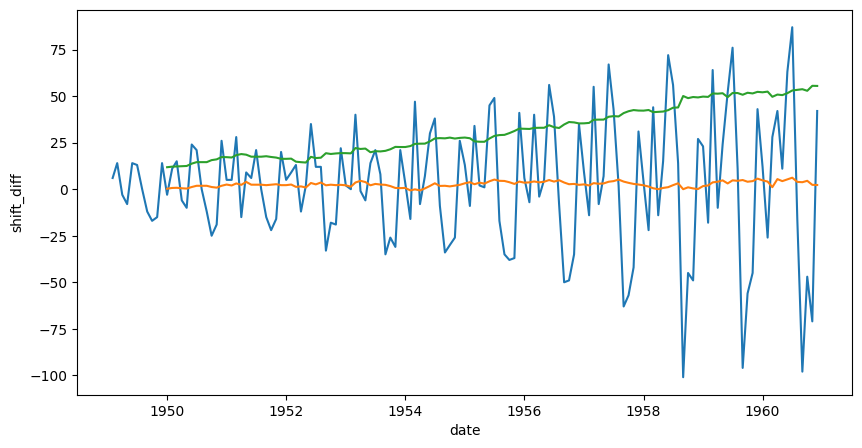

In [ ]:
air_df = df[['passengers']]
air_df['shift'] = air_df.passengers.shift()
air_df['shift_diff'] = air_df['passengers'] - air_df['shift']

adfuller_test(air_df.dropna(), 'shift_diff')

##Logarithmic

Test Statistic                  -1.717017
p-value                          0.422367
#lags used                      13.000000
number of observations used    130.000000
dtype: float64
criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


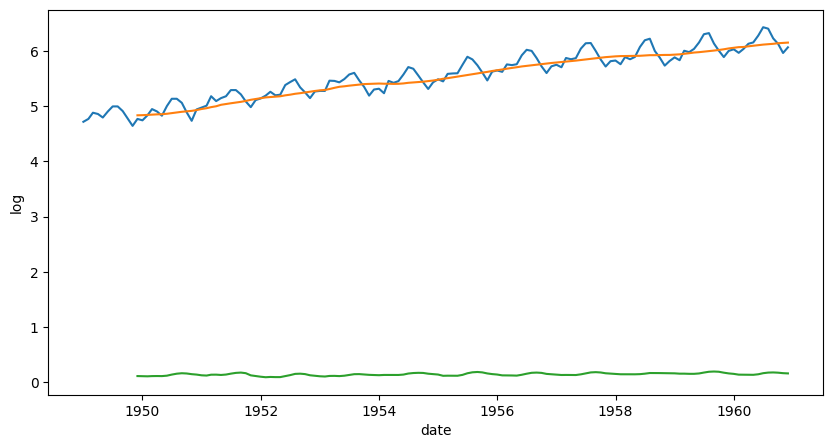

In [ ]:
log_df = df[['passengers']]
log_df['log'] = np.log(log_df['passengers'])
adfuller_test(log_df, 'log')

## Square Root



Test Statistic                  -0.345854
p-value                          0.918754
#lags used                      13.000000
number of observations used    130.000000
dtype: float64
criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


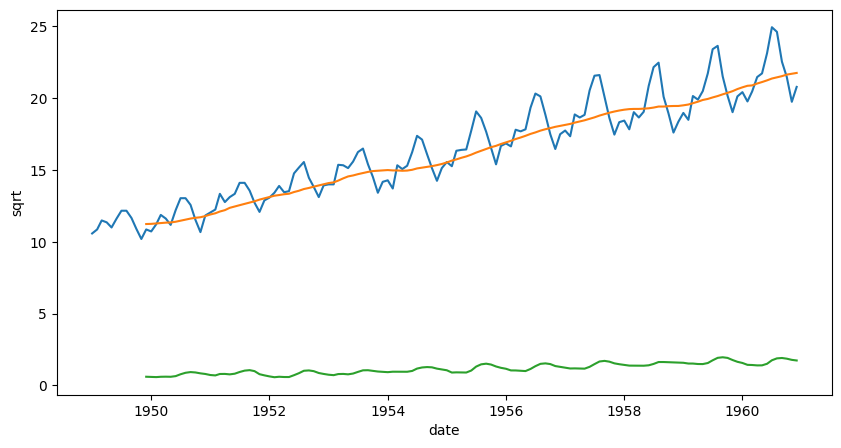

In [ ]:
sqrt_df = df[['passengers']]
sqrt_df['sqrt'] = np.sqrt(df['passengers'])
adfuller_test(sqrt_df, 'sqrt')

## Cubic Root

Test Statistic                  -0.810035
p-value                          0.816157
#lags used                      13.000000
number of observations used    130.000000
dtype: float64
criticality 1% : -3.4816817173418295
criticality 5% : -2.8840418343195267
criticality 10% : -2.578770059171598


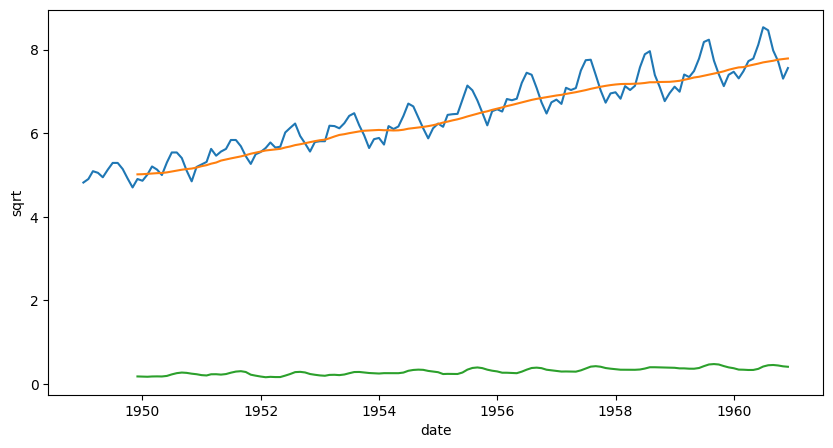

In [ ]:
cbrt_df = df[['passengers']]
cbrt_df['sqrt'] = np.cbrt(df['passengers'])
adfuller_test(cbrt_df, 'sqrt')

## Square root of Log

Test Statistic                  -2.611019
p-value                          0.090741
#lags used                      14.000000
number of observations used    128.000000
dtype: float64
criticality 1% : -3.4825006939887997
criticality 5% : -2.884397984161377
criticality 10% : -2.578960197753906


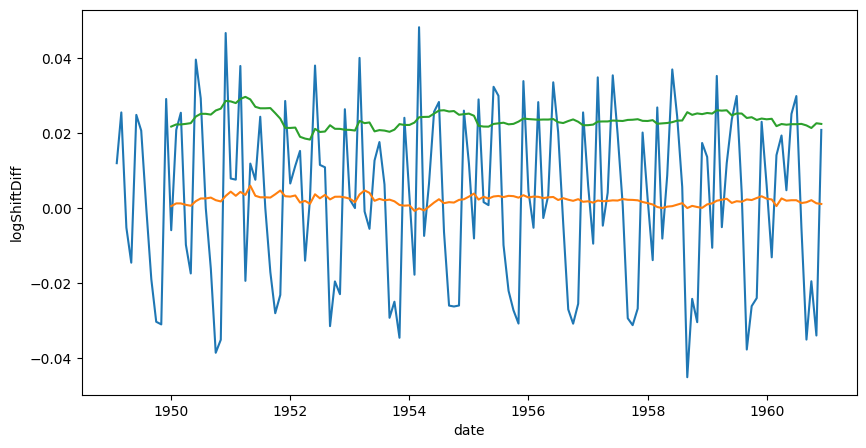

In [ ]:
log_df2 = log_df[['passengers','log']]
log_df2['log_sqrt'] = np.sqrt(log_df['log'])
log_df2['logShiftDiff'] = log_df2['log_sqrt'] - log_df2['log_sqrt'].shift()
adfuller_test(log_df2.dropna(),'logShiftDiff')

## Shifted Log

Test Statistic                  -2.717131
p-value                          0.071121
#lags used                      14.000000
number of observations used    128.000000
dtype: float64
criticality 1% : -3.4825006939887997
criticality 5% : -2.884397984161377
criticality 10% : -2.578960197753906


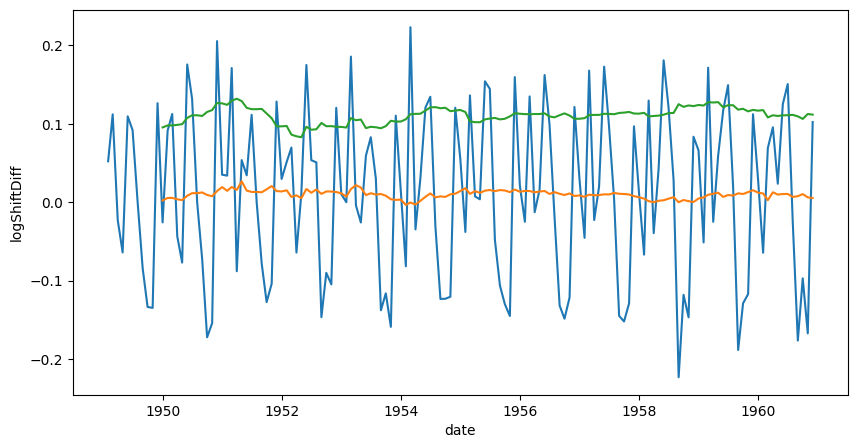

In [ ]:
log_shift = df[['passengers']].copy(deep=True)
log_shift['log'] = np.log(log_shift['passengers'])
log_shift['logShift'] = log_shift['log'].shift()
log_shift['logShiftDiff'] = log_shift['log'] - log_shift['logShift']
adfuller_test(log_shift.dropna(),'logShiftDiff')

In [ ]:
airP = df[['passengers']].copy(deep=True)
airP['firstDiff'] = airP['passengers'].diff()
airP['Diff12'] = airP['passengers'].diff(12)
airP.head()

,passengers,firstDiff,Diff12
date,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,NaN
1949-04-01,129,-3.0,NaN
1949-05-01,121,-8.0,NaN


<Figure size 1000x500 with 0 Axes>

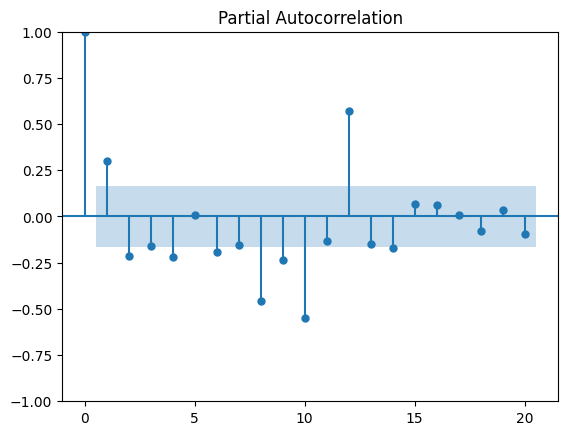

In [ ]:
plot_pacf(airP['firstDiff'].dropna(),lags=20);

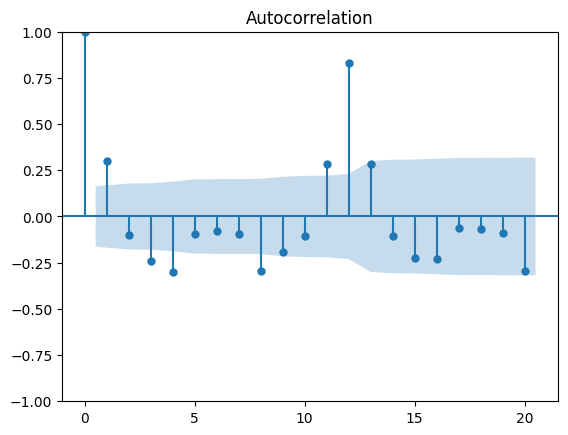

In [ ]:
plot_acf(airP['firstDiff'].dropna(),lags=20);

In [ ]:
train = airP[:round(len(airP)*70/100)]
test = airP[round(len(airP)*70/100):]
test.head()

,passengers,firstDiff,Diff12
date,,,
1957-06-01,422,67.0,48.0
1957-07-01,465,43.0,52.0
1957-08-01,467,2.0,62.0
1957-09-01,404,-63.0,49.0
1957-10-01,347,-57.0,41.0


In [ ]:
# p = 1, q = 3, d =1

model = ARIMA(train['passengers'],order=(1,1,3))
model_fit = model.fit()
prediction = model_fit.predict(start=test.index[0],end=test.index[-1])
airP['arimaPred'] = prediction
airP.tail()


,passengers,firstDiff,Diff12,arimaPred
date,,,,
1960-08-01,606,-16.0,47.0,341.111333
1960-09-01,508,-98.0,45.0,341.111333
1960-10-01,461,-47.0,54.0,341.111333
1960-11-01,390,-71.0,28.0,341.111333
1960-12-01,432,42.0,27.0,341.111333


<Axes: xlabel='date', ylabel='passengers'>

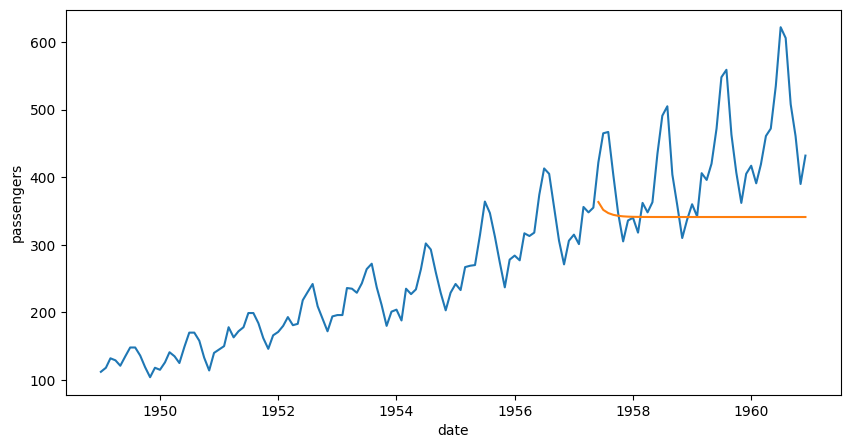

In [ ]:
airP.dropna()
plt.figure(figsize=[10,5])
sns.lineplot(data=airP,x=airP.index,y='passengers')
sns.lineplot(data=airP,x=airP.index,y='arimaPred')

In [ ]:
np.sqrt(mean_squared_error(test['passengers'],prediction))

111.1101033142743

# SARIMAX

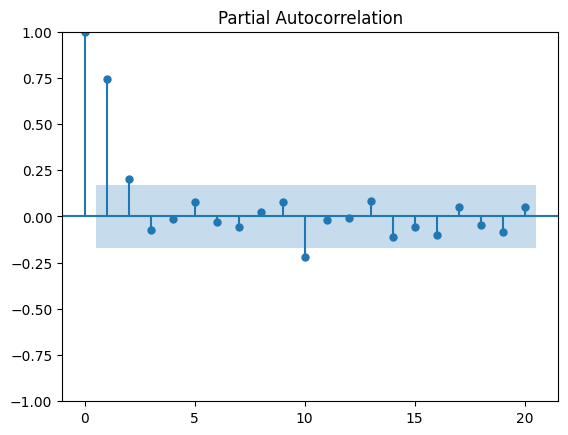

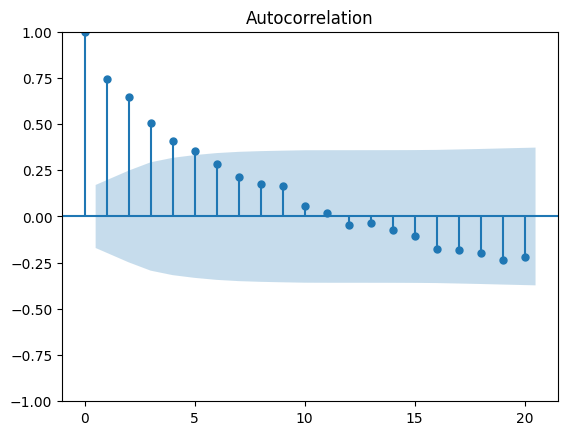

In [ ]:
plot_pacf(airP['Diff12'].dropna(),lags=20);
plot_acf(airP['Diff12'].dropna(),lags=20);

In [ ]:
# p = 1, q = 3, d =1

model = SARIMAX(train['passengers'],order=(1,1,3),seasonal_order=(2,1,2,12))
model_fit = model.fit()
prediction = model_fit.predict(start=test.index[0],end=test.index[-1])
airP['sarimaxPred'] = prediction
airP.tail()

,passengers,firstDiff,Diff12,arimaPred,sarimaxPred
date,,,,,
1960-08-01,606,-16.0,47.0,341.111333,598.353085
1960-09-01,508,-98.0,45.0,341.111333,533.984201
1960-10-01,461,-47.0,54.0,341.111333,478.758382
1960-11-01,390,-71.0,28.0,341.111333,431.404548
1960-12-01,432,42.0,27.0,341.111333,476.766689


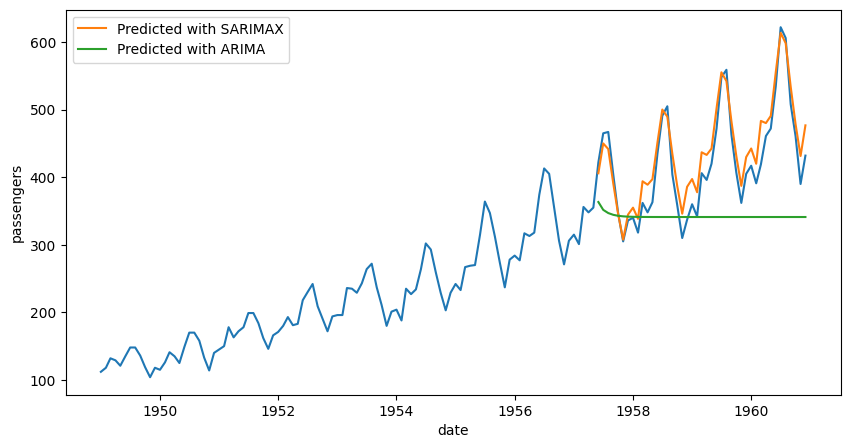

In [ ]:
plt.figure(figsize=[10,5])
airP.dropna()
sns.lineplot(data=airP,x=airP.index,y='passengers')
sns.lineplot(data=airP,x=airP.index,y='sarimaxPred',label = 'Predicted with SARIMAX')
sns.lineplot(data=airP,x=airP.index,y='arimaPred',label = 'Predicted with ARIMA')

In [ ]:
np.sqrt(mean_squared_error(test['passengers'],prediction))

27.475919453770423

In [ ]:
futureDate = pd.DataFrame(pd.date_range(start='1961-01-01', end='1962-12-01',freq='MS'),columns=['Dates'])
futureDate.set_index('Dates',inplace=True)
futureDate.head()


""
Dates
1961-01-01
1961-02-01
1961-03-01
1961-04-01
1961-05-01


In [ ]:
model_fit.predict(start=futureDate.index[0],end=futureDate.index[-1])

1961-01-01    490.589402
1961-02-01    465.056862
1961-03-01    532.843397
1961-04-01    530.133489
1961-05-01    541.960109
1961-06-01    612.593540
1961-07-01    674.599932
1961-08-01    657.105554
1961-09-01    588.114077
1961-10-01    528.837213
1961-11-01    478.537050
1961-12-01    526.590439
1962-01-01    541.477575
1962-02-01    513.090033
1962-03-01    585.172404
1962-04-01    582.897588
1962-05-01    595.857510
1962-06-01    671.869247
1962-07-01    737.981041
1962-08-01    718.344171
1962-09-01    644.884477
1962-10-01    581.666671
1962-11-01    528.529539
1962-12-01    579.177906
Freq: MS, Name: predicted_mean, dtype: float64

<Axes: xlabel='date', ylabel='passengers'>

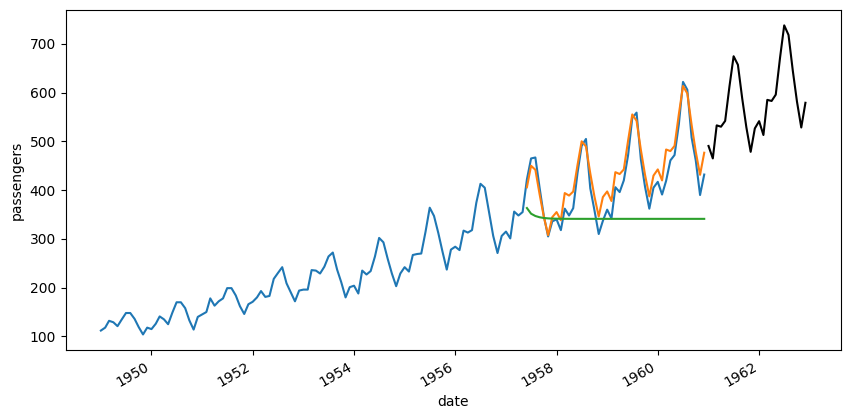

In [ ]:
airP.dropna()
plt.figure(figsize=[10,5])
sns.lineplot(data=airP,x=airP.index,y='passengers')
sns.lineplot(data=airP,x=airP.index,y='sarimaxPred')
sns.lineplot(data=airP,x=airP.index,y='arimaPred')
model_fit.predict(start=futureDate.index[0],end=futureDate.index[-1]).plot(color='black')